In [ ]:
# import os, sys
# from google.colab import drive
# drive.mount('/content/drive')
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

In [ ]:
# %%capture
# !pip install --target=$nb_path huggingface-hub
# !pip install --target=$nb_path transformers
# !pip install --target=$nb_path datasets
# !pip install sentence-transformers

# some libraries are also installed in the middle of the notebook

In [ ]:
%%capture
!pip install huggingface-hub
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets

Download a fine-tuned model from Hface and use it in a pipeline

a BERT-base model that achieves around 94% accuracy on the CLINC150 dataset which includes 22,500 in-scope queries across 150 intents and 10 domains like banking and travel, and also includes 1,200 out-of-scope queries that belong to an oos intent class.

In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

Trade offs in production for any ML model

1.   Model Performance
2.   Latency
3.   Memory



In [ ]:
# Template or a skeleton to what will be done in this notebook

class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        # define this later
        pass

    def compute_size(self):
        # define this later
        pass

    def time_pipeline(self):
        # define this later
        pass

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

# Get the test dataset

In [ ]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

***plus*** configuration refers to the subset that contains the out-of-scope training examples.

In [ ]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [ ]:
len(clinc["test"])

5500

In [ ]:
intents = clinc["test"].features["intent"]

In [ ]:
intents.int2str(sample["intent"])

'transfer'

In [ ]:
just_intents = [clinc["test"][x]['intent'] for x in range(len(clinc["test"]))]

In [ ]:
just_intents[:5]

[61, 61, 61, 61, 61]

In [ ]:
import pandas as pd
intent_id_df = pd.DataFrame(data=just_intents, columns=["intent_id"])

In [ ]:
intent_id_df.value_counts(normalize=True)

intent_id
42           0.181818
0            0.005455
104          0.005455
97           0.005455
98           0.005455
               ...   
51           0.005455
52           0.005455
53           0.005455
54           0.005455
150          0.005455
Length: 151, dtype: float64

In [ ]:
intents.int2str(42)

'oos'

In [ ]:
pipe(clinc["test"][42]["text"])

[{'label': 'transfer', 'score': 0.5653554797172546}]

Except the ***oos*** or Out-of-Scope intent, all intents are in the same proportion

(the value_counts will give a sorted proportion list)

Hence we can use **accuracy** as the metric

In [ ]:
from datasets import load_metric

accuracy_score = load_metric("accuracy")

<ipython-input-17-7176c65eea59>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


Based on the above warning, load_metric is deprecated, instead use the Evaluate library

In [ ]:
# %%capture
# !pip install evaluate

In [ ]:
# from evaluate import load

# new_accuracy_score = load("accuracy")

## Fill the accuracy computation function in the above template class

The pipeline will predict labels or intents in string format,

but to compute accuracy, we need integers for comparison purposes

In [ ]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        # print(example)
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    # acc_new_library = new_accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    # print(f"Accuracy on test set using evaluate library - {acc_new_library['accuracy']:.3f}")
    return accuracy


In [ ]:
PerformanceBenchmark.compute_accuracy = compute_accuracy

## Model size using torch.save()

In [ ]:
list(pipe.model.state_dict().items())[42]


('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

## Compute size

In [ ]:
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

## Average latency per query

In [ ]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 198.025
Latency (ms) - 293.959
Latency (ms) - 174.670


#### Timing a single pass through the pipeline can give wildly different results each time we run the code

In [ ]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [ ]:
benchmark = PerformanceBenchmark(pipeline=pipe, dataset=clinc["test"])


In [ ]:
# benchmark.compute_accuracy()
# benchmark.compute_size()
# benchmark.time_pipeline()

In [ ]:
perf_metrics = benchmark.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 166.24 +\- 65.66
Accuracy on test set - 0.867


In absolute terms, these numbers for latency or model size or accuracy wont make sense unless we compare against an optimised model.

Now we will test different strategies to reduce each of these parameters.

# Knowledge Distilation - make the models smaller

Details are in the notes/text/blog where it is shown how the scaling is done with Temperature and how the new loss function is weighted average of the cross entropy loss and the KLDivergence loss.

### Training arguments with Temperature and alpha

In [ ]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

## New Distillation Trainer
Include the new loss function by overriding the compute_loss function

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Taking DistilBert for student initialisation

In [ ]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [ ]:
# !pip install accelerate -U

In [ ]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"

student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
    push_to_hub=True)

In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [ ]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [ ]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
distilbert_trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.276164,0.728387
2,3.782400,1.862351,0.835806
3,3.782400,1.151239,0.898387
4,1.685800,0.853978,0.913226
5,0.898300,0.772440,0.915806


TrainOutput(global_step=1590, training_loss=2.0452332166755722, metrics={'train_runtime': 325.0042, 'train_samples_per_second': 234.612, 'train_steps_per_second': 4.892, 'total_flos': 413013830824140.0, 'train_loss': 2.0452332166755722, 'epoch': 5.0})

In [ ]:
distilbert_trainer.push_to_hub("Training completed!")

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

'https://huggingface.co/pradeepiisc/distilbert-base-uncased-finetuned-clinc/tree/main/'

In [ ]:
finetuned_ckpt = "pradeepiisc/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [ ]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 38.96 +\- 2.58
Accuracy on test set - 0.855


In [ ]:
perf_metrics = {'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 166.23851966000018,
  'time_std_ms': 65.6637835799195,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 38.95798757000307,
  'time_std_ms': 2.578577762061873,
  'accuracy': 0.8552727272727273}}

In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 166.23851966000018,
  'time_std_ms': 65.6637835799195,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 38.95798757000307,
  'time_std_ms': 2.578577762061873,
  'accuracy': 0.8552727272727273}}

Plot the metrics

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

<ipython-input-35-f9515d53f9e1>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


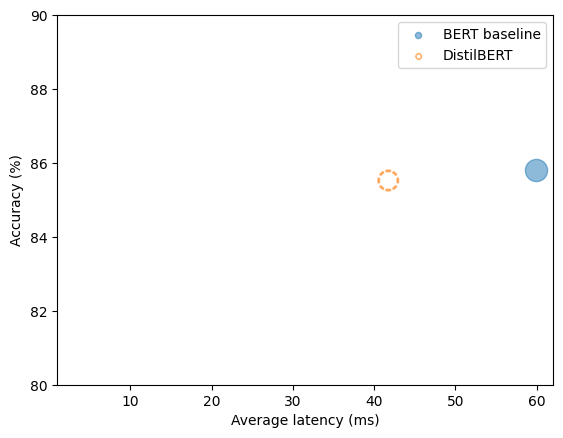

In [ ]:
plot_metrics(perf_metrics, optim_type)

### Hyperparameter search through Optuna

First define the hyperparameter space that we wish to optimize over, for alpha and T

we then need to specify the number of trials to run and,  

a direction to optimize for, eg. direction="maximize"

In [ ]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
          "alpha": trial.suggest_float("alpha", 0, 1),
          "temperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
%%capture

!pip install optuna
!pip install ray[tune]
!pip install sigopt
!pip install wandb

In [ ]:
#Kept n_trials as 5 instead of 20 to reduce the time to optimize
best_run = distilbert_trainer.hyperparameter_search(
      n_trials=4, direction="maximize", hp_space=hp_space)

[I 2023-09-13 11:12:09,939] A new study created in memory with name: no-name-4516a7e5-3e2b-48b9-b985-6bd8ddc175ff
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
print(best_run)

The value of alpha suggest most of the training signal is coming from the knowledge distillation term

we will update our training arguments with these values and run the final training run

In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)



In [ ]:
distil_trainer.train()

In [ ]:
distil_trainer.push_to_hub("Training complete")

## Benchmark the distillation

In [ ]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
# If the above model is trained and pushed to personal huggingface accouont, remove transformersbook/ from above line
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 109.44 +\- 45.68
Accuracy on test set - 0.868


In [ ]:
perf_metrics = {'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 166.23851966000018,
  'time_std_ms': 65.6637835799195,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 38.95798757000307,
  'time_std_ms': 2.578577762061873,
  'accuracy': 0.8552727272727273},
 'Distillation': {'size_mb': 255.88143634796143,
  'time_avg_ms': 109.43876887999636,
  'time_std_ms': 45.67907648048472,
  'accuracy': 0.8683636363636363}}

In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 166.23851966000018,
  'time_std_ms': 65.6637835799195,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 38.95798757000307,
  'time_std_ms': 2.578577762061873,
  'accuracy': 0.8552727272727273},
 'Distillation': {'size_mb': 255.88143634796143,
  'time_avg_ms': 109.43876887999636,
  'time_std_ms': 45.67907648048472,
  'accuracy': 0.8683636363636363}}

<ipython-input-36-f9515d53f9e1>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


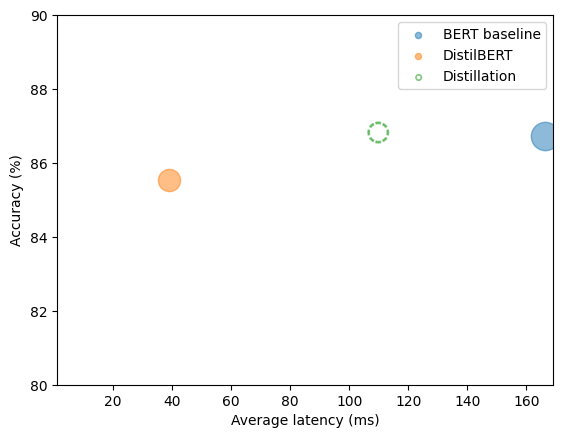

In [ ]:
plot_metrics(perf_metrics, optim_type)

Accuracy has improved to the extent that it beats the original BERT method but it is possible due to the fact that BERT was not fine tuned as we did it for DistilBert using Optuna.

# Quantization

Why Transformers are ideal for quantization ?

pick out one of the attention weight matrices from our distilled model and plot the frequency distribution of the values

Plot to show that weights and activations tend to take values between a smaller range

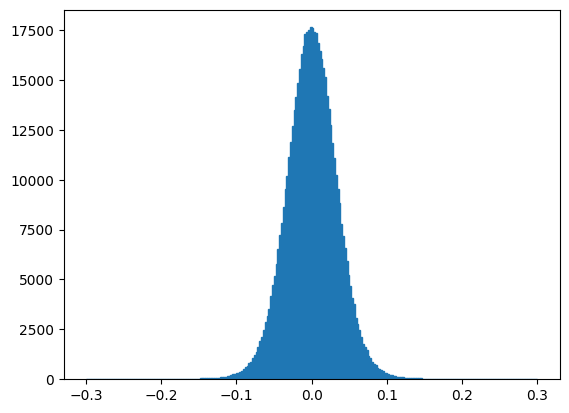

In [ ]:
import matplotlib.pyplot as plt
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

Quantization of the above tensor is done as follows

In [ ]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [ ]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   5,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  11,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

In [ ]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  9,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -5,   5,  ...,   0,   5,  -3],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  11,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -1]], dtype=torch.int8)

Time taken to multiple two tensors - FP32 and INT8

In [ ]:
%%timeit
weights @ weights

7.86 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [ ]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

233 µs ± 5.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


INT8 tensor multiplication is at least 100times faster than the FP32 tensor multiplication

Also, INT8 is 4 times space efficient compared to FP32

In [ ]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

<ipython-input-51-600687c2638a>:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

Dynamic Quantization

In [ ]:
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

## Benchmarkign the Quantized model

In [ ]:
pipe = pipeline("text-classification", model=model_quantized,
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 34.19 +\- 33.20
Accuracy on test set - 0.876


In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 166.23851966000018,
  'time_std_ms': 65.6637835799195,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 38.95798757000307,
  'time_std_ms': 2.578577762061873,
  'accuracy': 0.8552727272727273},
 'Distillation': {'size_mb': 255.88143634796143,
  'time_avg_ms': 109.43876887999636,
  'time_std_ms': 45.67907648048472,
  'accuracy': 0.8683636363636363},
 'Distillation + quantization': {'size_mb': 132.3907289505005,
  'time_avg_ms': 34.190072500005044,
  'time_std_ms': 33.1990029983173,
  'accuracy': 0.8758181818181818}}

<ipython-input-36-f9515d53f9e1>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


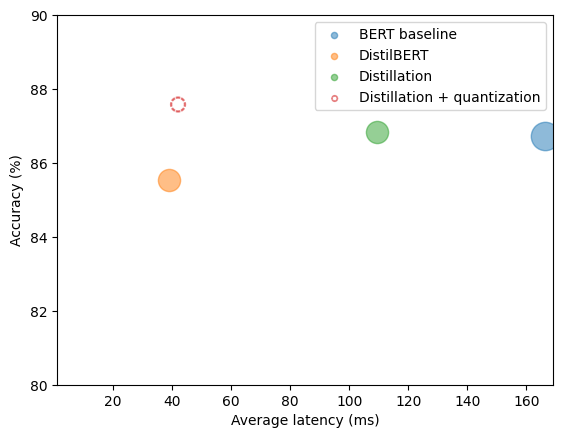

In [ ]:
plot_metrics(perf_metrics, optim_type)

the quantized model is almost half the size of our distilled one and has even gained a slight accuracy boost!

## Optimizing Inference using ONNX and the ONNX Runtime

In [ ]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [ ]:
# !pip install --upgrade onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 26.7 MB/s eta 0:00:00


In [ ]:
import onnx

In [ ]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

ONNX opset version set to: 12
Loading pipeline (model: transformersbook/distilbert-base-uncased-distilled-clinc, tokenizer: DistilBertTokenizerFast(name_or_path='transformersbook/distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True))
Creating folder onnx
Using framework PyTorch: 2.0.1+cu118
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
============

### create an InferenceSession instance to feed inputs to the model

In [ ]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.7 MB/s eta 0:00:00


In [ ]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession,
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [ ]:
onnx_model = create_model_for_provider(onnx_model_path)

Test on a sample

In [ ]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

Get the label using argmax on the logits

In [ ]:
np.argmax(logits_onnx) == clinc_enc["test"][0]["labels"]

True

ONNX pipeline is not compatible with the text-classification pipeline -> create a custome ONNXPipeline

In [ ]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [ ]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.7848335}]

### Benchmarking the ONNX model

Override the compute_size method as the Pytorch's nn.Module are available for pytorch model and not for ONNX InferenceSession object.

In [ ]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [ ]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.98
Average latency (ms) - 36.49 +\- 13.16
Accuracy on test set - 0.868


In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 166.23851966000018,
  'time_std_ms': 65.6637835799195,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 38.95798757000307,
  'time_std_ms': 2.578577762061873,
  'accuracy': 0.8552727272727273},
 'Distillation': {'size_mb': 255.88143634796143,
  'time_avg_ms': 109.43876887999636,
  'time_std_ms': 45.67907648048472,
  'accuracy': 0.8683636363636363},
 'Distillation + quantization': {'size_mb': 132.3907289505005,
  'time_avg_ms': 34.190072500005044,
  'time_std_ms': 33.1990029983173,
  'accuracy': 0.8758181818181818},
 'Distillation + ORT': {'size_mb': 255.97955417633057,
  'time_avg_ms': 36.48752942000556,
  'time_std_ms': 13.160957400693967,
  'accuracy': 0.8683636363636363}}

<ipython-input-38-f9515d53f9e1>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


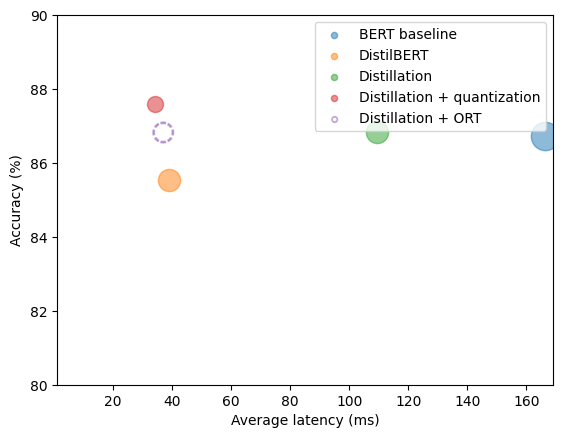

In [ ]:
plot_metrics(perf_metrics, optim_type)

### Add quantization and distillation both to the ONNX model

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)


Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.0/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.1/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.2/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.3/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.4/attention/MatMul_1]
Ignore MatMul due to non constant B: /[/distilbert/transformer/layer.5/attention/MatMul]
Ignore MatM

In [ ]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.33


In [ ]:
perf_metrics

{'BERT baseline': {'size_mb': 418.14669132232666,
  'time_avg_ms': 166.23851966000018,
  'time_std_ms': 65.6637835799195,
  'accuracy': 0.8672727272727273},
 'DistilBERT': {'size_mb': 255.88143634796143,
  'time_avg_ms': 38.95798757000307,
  'time_std_ms': 2.578577762061873,
  'accuracy': 0.8552727272727273},
 'Distillation': {'size_mb': 255.88143634796143,
  'time_avg_ms': 109.43876887999636,
  'time_std_ms': 45.67907648048472,
  'accuracy': 0.8683636363636363},
 'Distillation + quantization': {'size_mb': 132.3907289505005,
  'time_avg_ms': 34.190072500005044,
  'time_std_ms': 33.1990029983173,
  'accuracy': 0.8758181818181818},
 'Distillation + ORT': {'size_mb': 255.97955417633057,
  'time_avg_ms': 36.48752942000556,
  'time_std_ms': 13.160957400693967,
  'accuracy': 0.8683636363636363},
 'Distillation + ORT (quantized)': {'size_mb': 64.32713317871094,
  'time_avg_ms': 9.877807020006912,
  'time_std_ms': 0.8944657958632478,
  'accuracy': 0.8756363636363637}}

<ipython-input-38-f9515d53f9e1>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


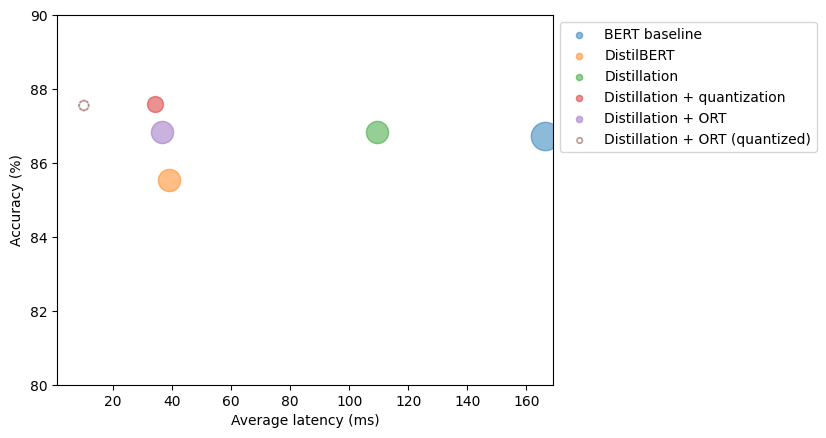

In [ ]:
plot_metrics(perf_metrics, optim_type)

ORT quantization has reduced the model size and latency by around 30% compared to the model obtained from PyTorch quantization (the distillation + quantization blob). One reason for this is that PyTorch only optimizes the nn.Linear modules, while ONNX quantizes the embedding layer as well.